In [1]:
import SIMSIToolBox
import seaborn as sb
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.dpi'] = 200
import os
import pandas as pd
import numpy as np
from scipy.interpolate import interp1d
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from copy import deepcopy

In [2]:
datadir = "X:/MSI_Shared_Data/13CImagingManuscript/raw_data/imzmls/subset_data/NA_corrected_data/manuscript_figs/figure5/"

In [3]:
formula = "C20H31O2" #should be the adducted form of the metabolite (protenated or deprotenated)
polarity="negative"
num_cores=10
ppmThresh = 50
colormap = "CMRmap" #coloring for images, see https://matplotlib.org/3.1.1/gallery/color/colormap_reference.html

colormap = LinearSegmentedColormap.from_list("test",colors=["black", "navy","blue","cyan","yellow","orange","orangered","red","mistyrose","white"],N=256)


def cmap_custom(val,alpha,minim,maxim):
    
    val_norm = (val - minim) / (maxim - minim)
    
    #rgba mapping
    r = interp1d([0,.5,1.0],[0,.5,1.0])
    g = interp1d([0,.5,1.0],[0.0,0.0,0.0])
    b = interp1d([0,.5,1.0],[0.0,0.0,0.0])
    
    return (r(val_norm),g(val_norm),b(val_norm),alpha)

def apply_cmap(arr,alpha):
    sh = arr.shape
    arr = arr.flatten()
    minim = np.min(arr)
    maxim = np.max(arr)
    arr = np.array([cmap_custom(x,alpha,minim,maxim) for x in arr])
    arr = arr.reshape(list(sh) + [arr.shape[1]])
    return arr



In [4]:
files = [x for x in os.listdir(datadir) if ".csv" in x]# and formula in x]
files

['20210223_02_100w120h_13CtumorBrain2_009109H_01 009109H_1.csv',
 '20210223_02_100w120h_13CtumorBrain2_009109H_01 009109H_1_C20H31O2.csv',
 '20210301_02_90w115h_13CnontumorBrain5_02824A_01 02824A_1.csv',
 '20210301_02_90w115h_13CnontumorBrain5_02824A_01 02824A_1_C20H31O2.csv']

In [5]:
file = files[1]

In [6]:
m0Mz,mzsOI,numCarbons = SIMSIToolBox.getMzsOfIsotopologues(formula,elementOfInterest="C")
msi = SIMSIToolBox.MSIData(mzsOI,ppm=ppmThresh,numCores = num_cores,intensityCutoff=0)
df = pd.read_csv(datadir + file,index_col=0)
msi.from_pandas(df,polarity)

In [7]:
os.mkdir(datadir + file.replace(".csv","/"))

FileExistsError: [WinError 183] Cannot create a file when that file already exists: 'X:/MSI_Shared_Data/13CImagingManuscript/raw_data/imzmls/subset_data/NA_corrected_data/manuscript_figs/figure5/20210223_02_100w120h_13CtumorBrain2_009109H_01 009109H_1_C20H31O2/'

c:\users\ethan\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


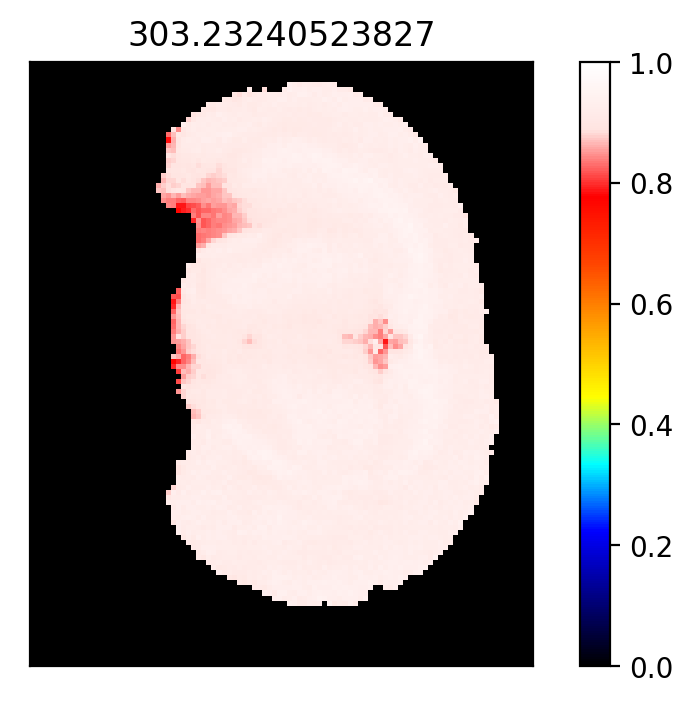

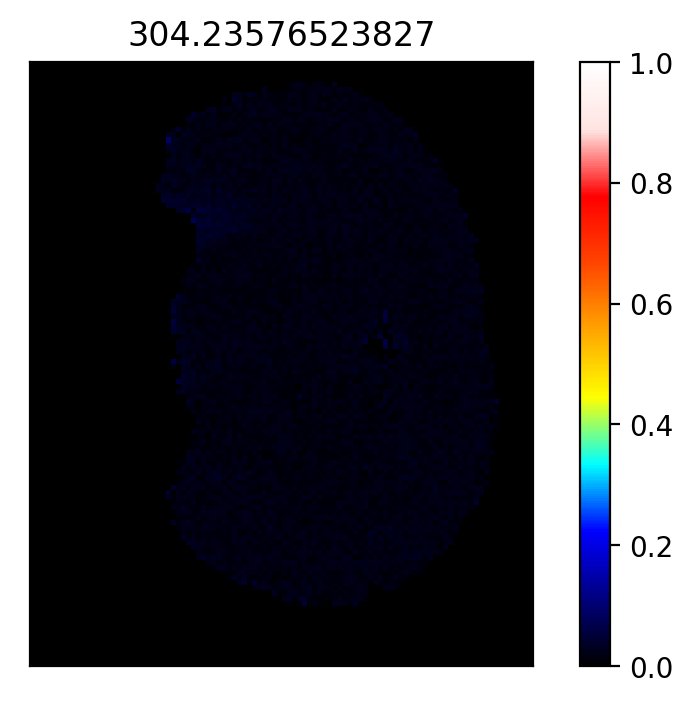

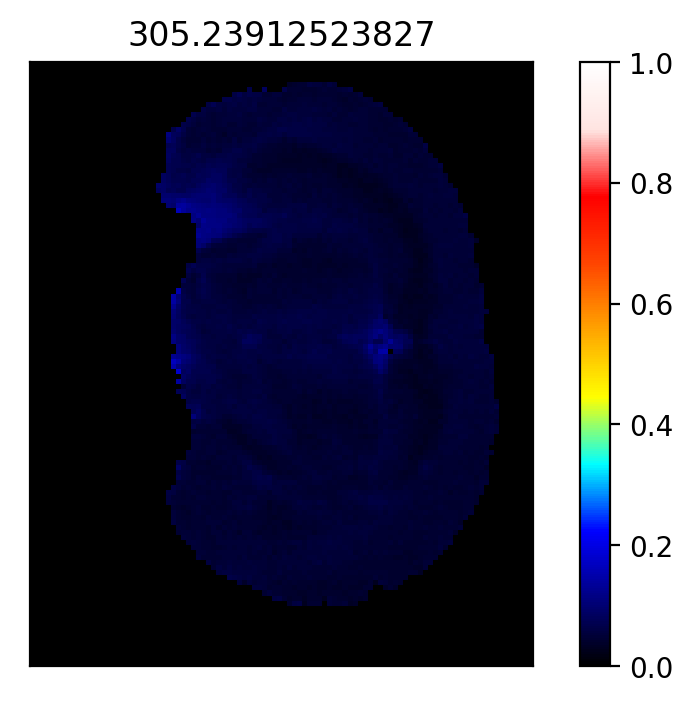

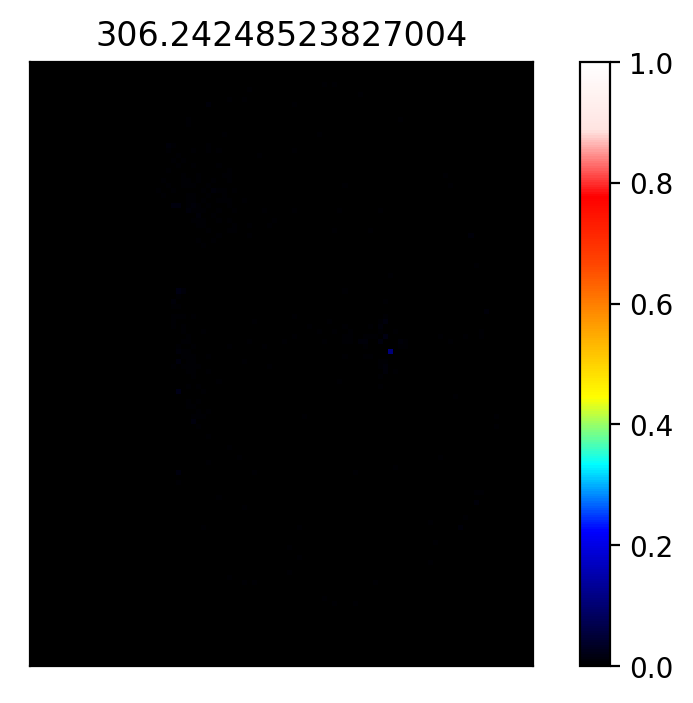

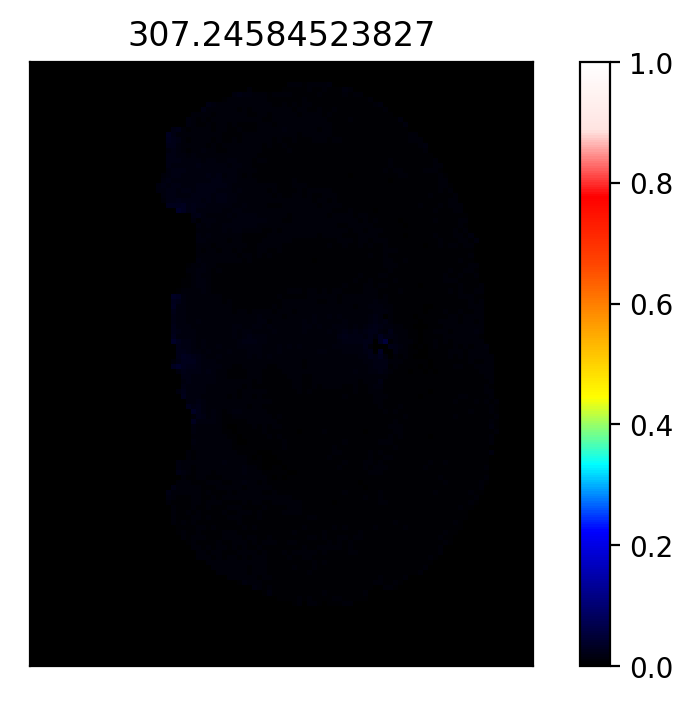

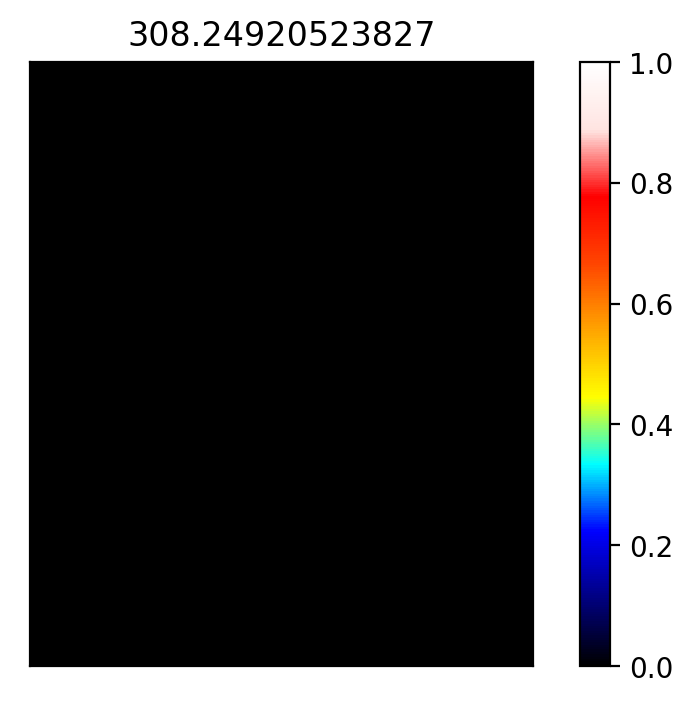

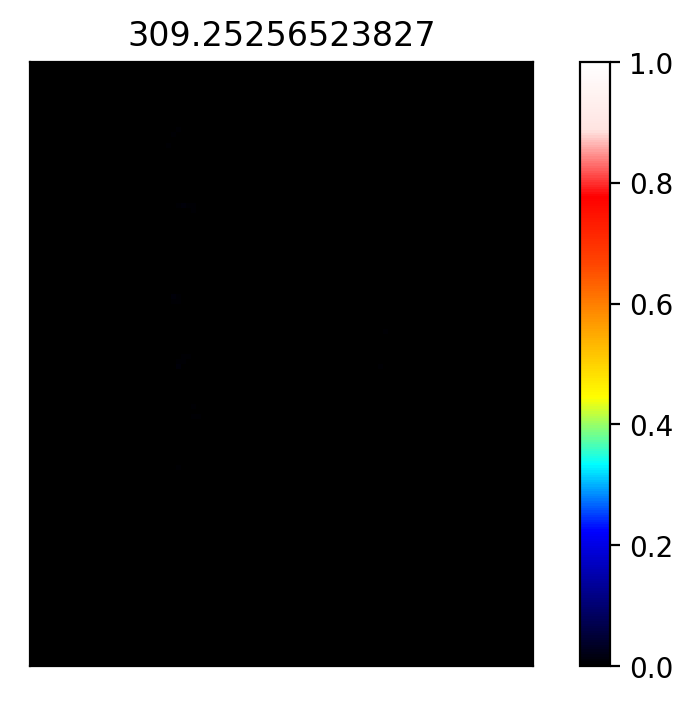

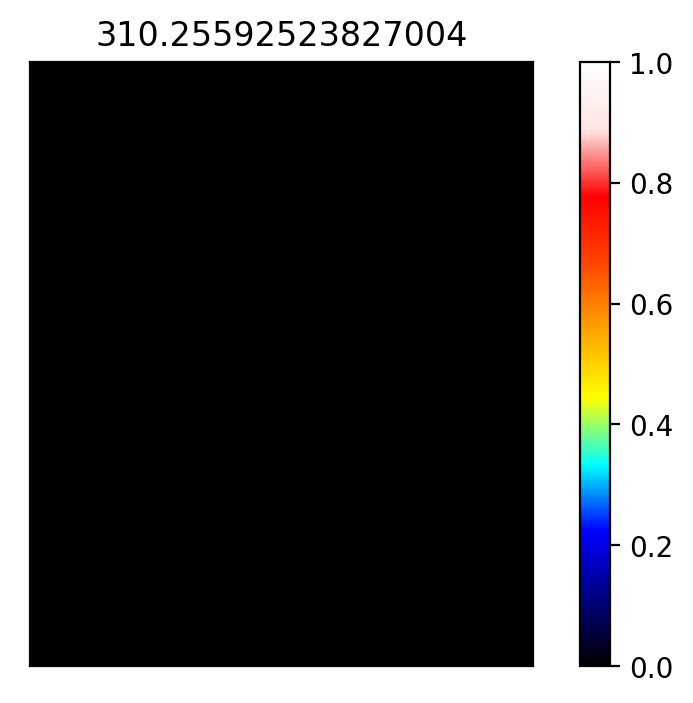

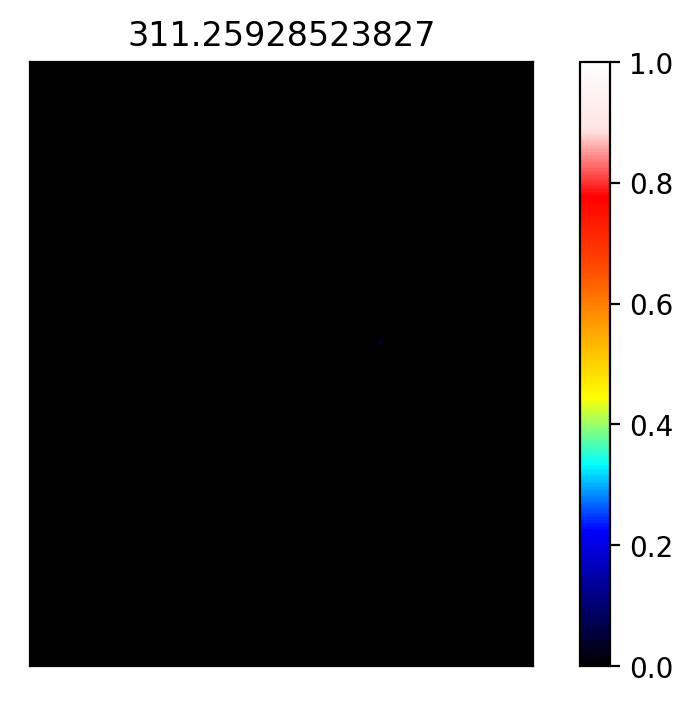

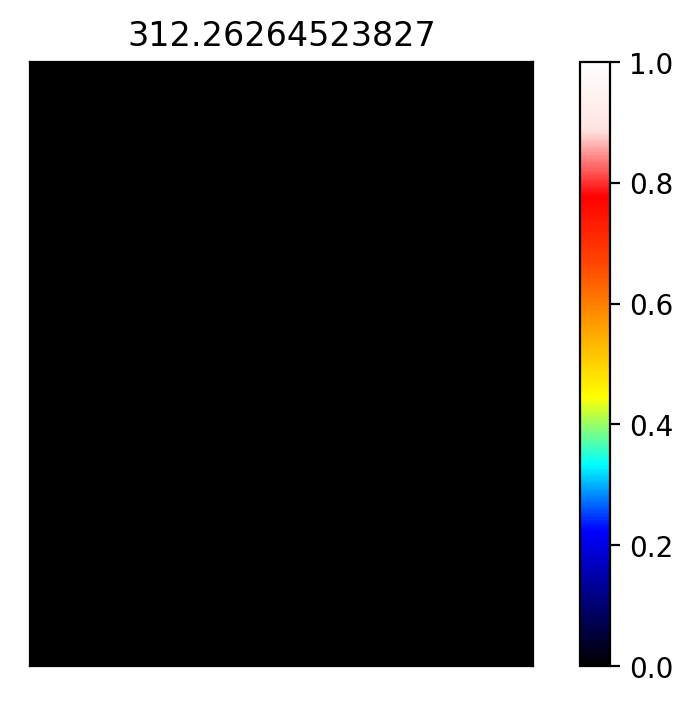

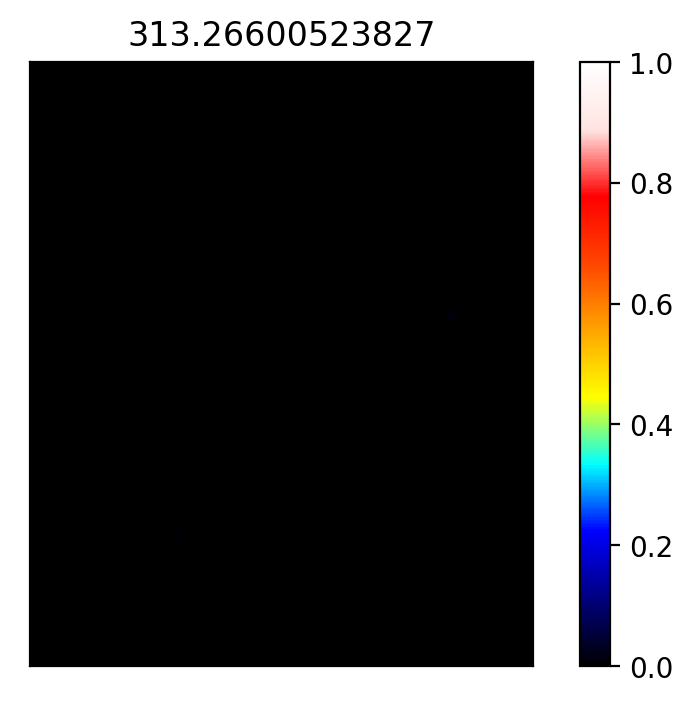

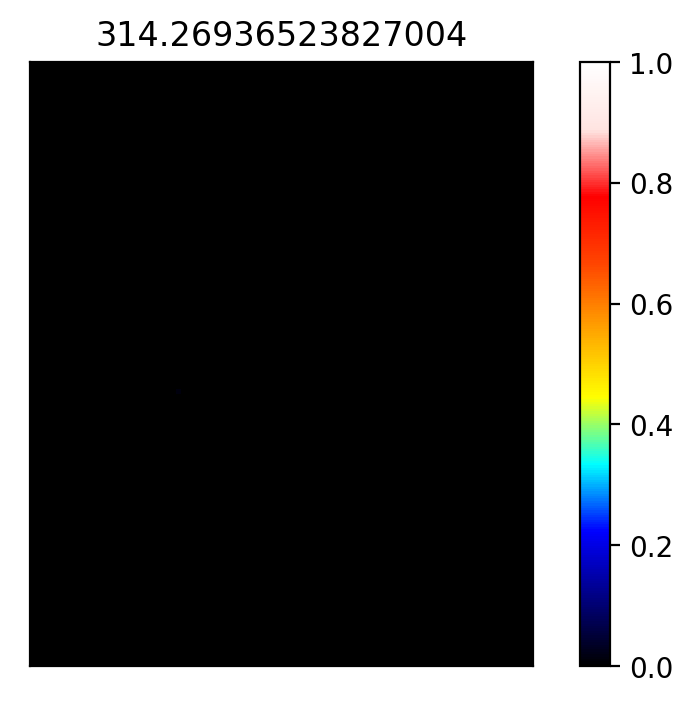

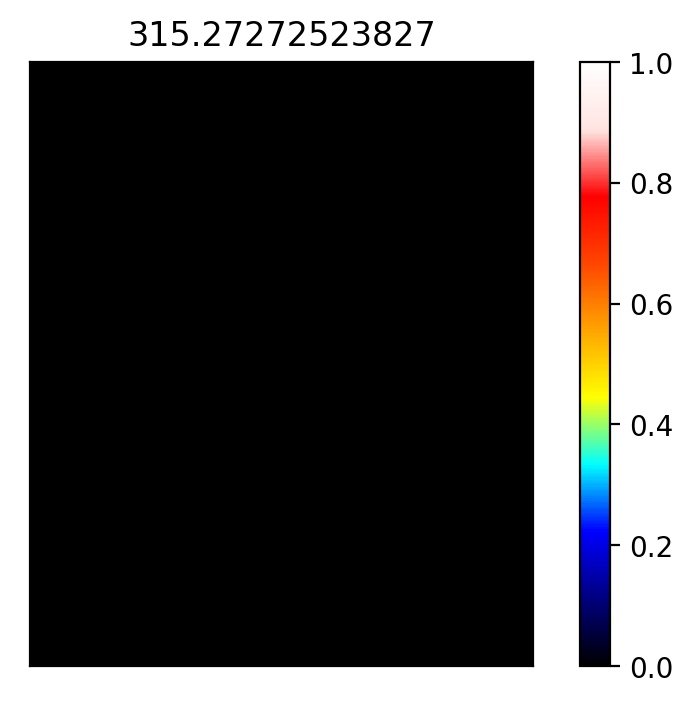

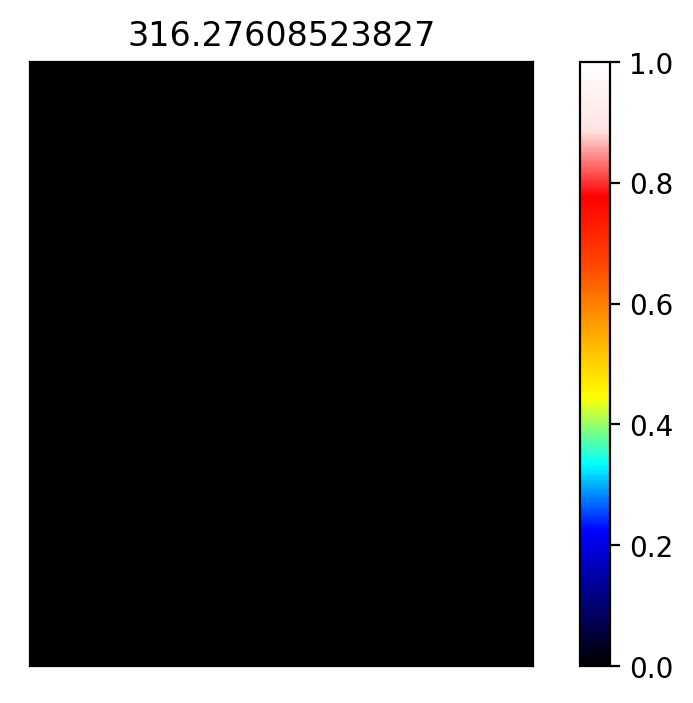

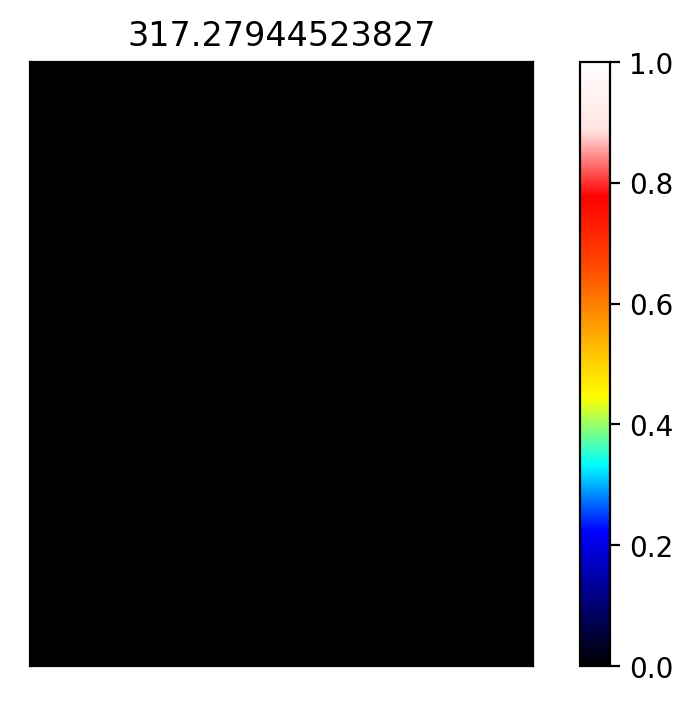

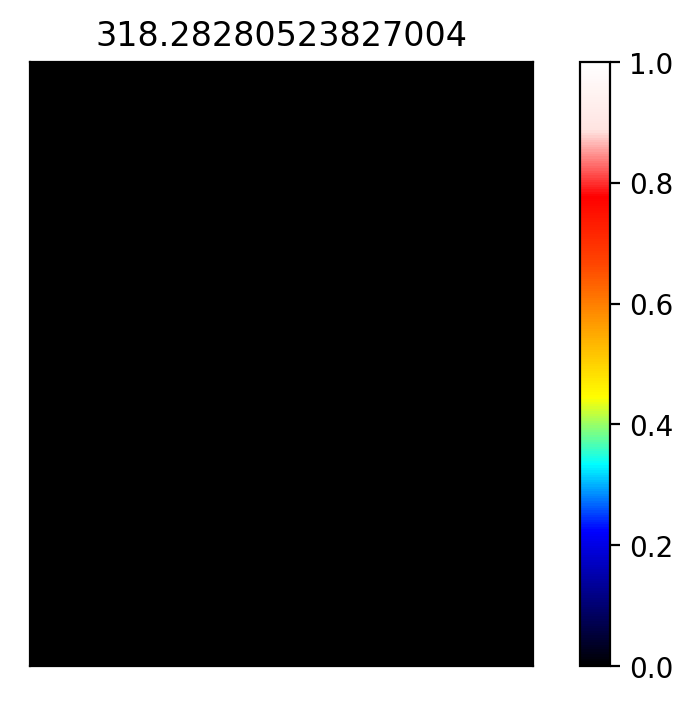

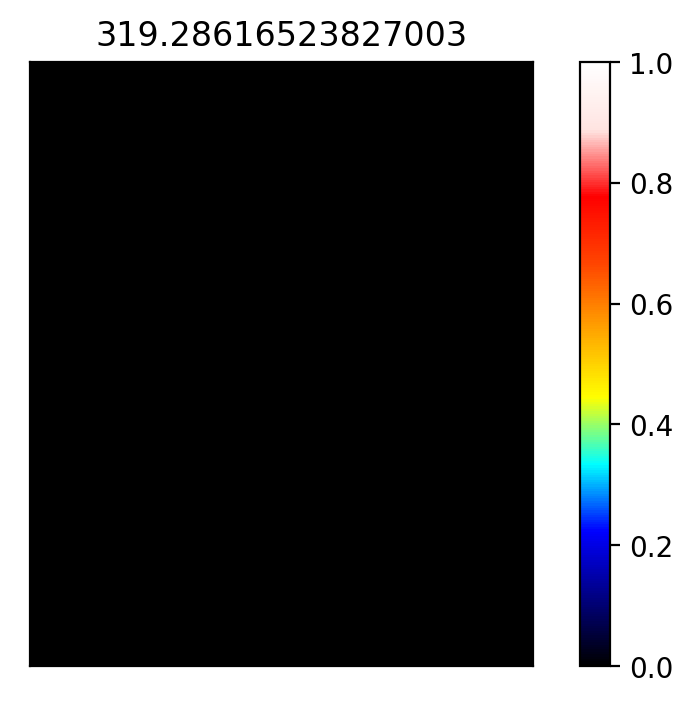

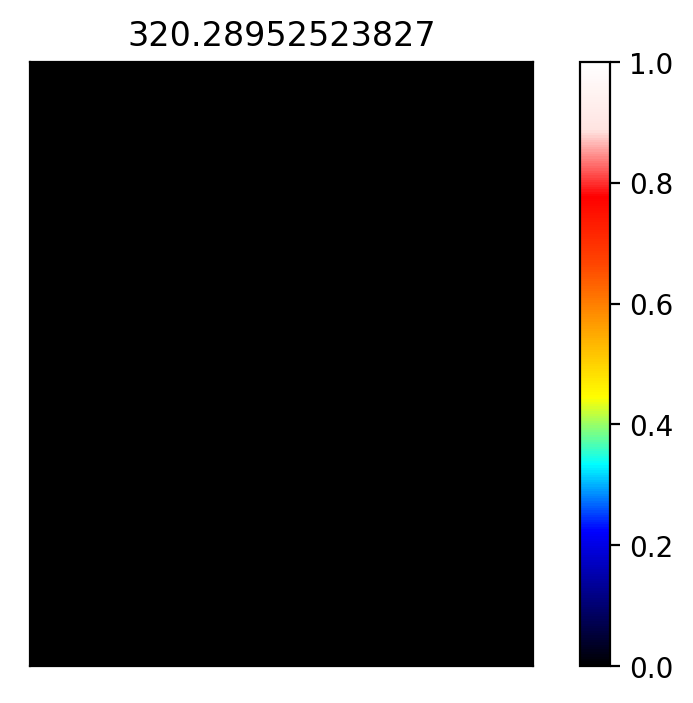

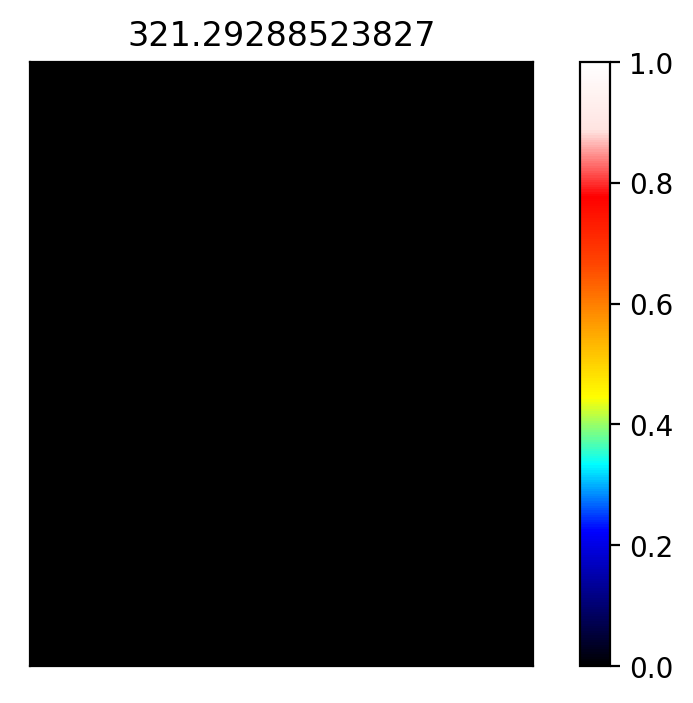

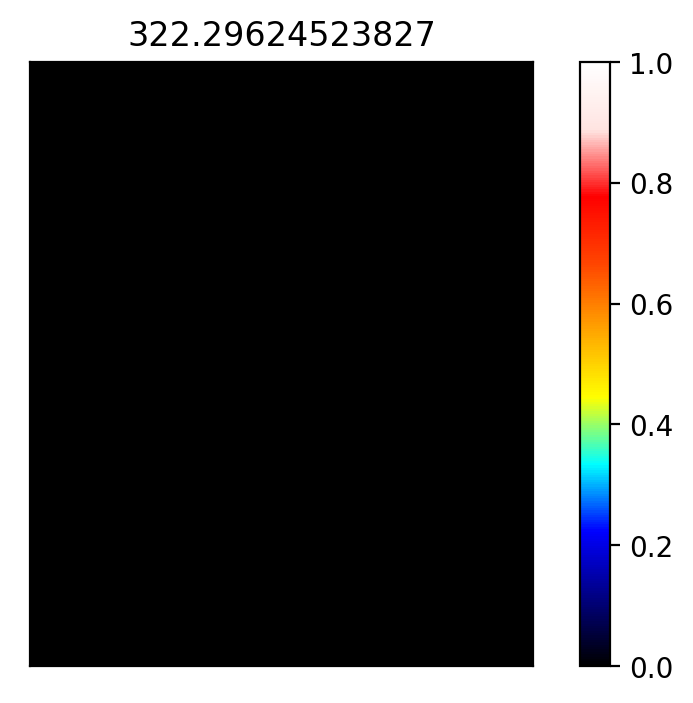

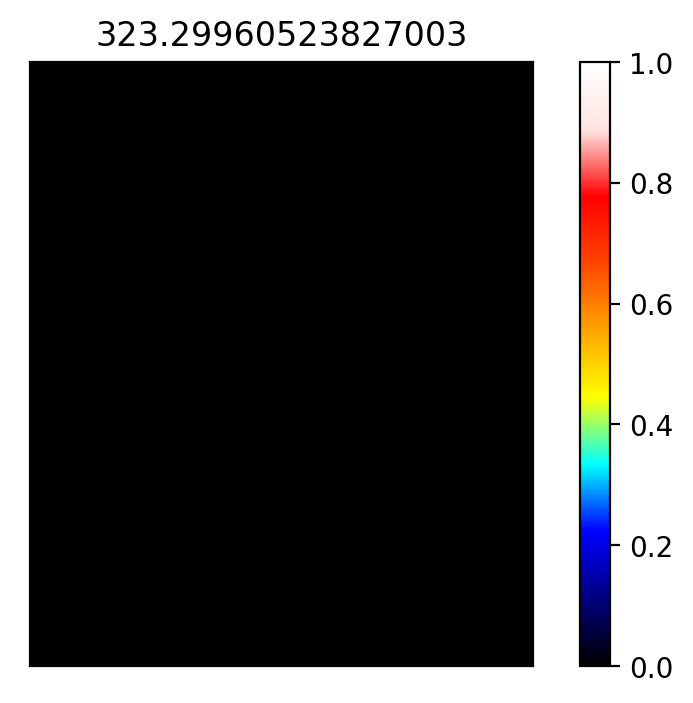

In [9]:
#calculation labeling pattern images and save result
goodInds = [x for x in range(len(msi.data_tensor))]

iso_tensor = SIMSIToolBox.normalizeTensor(msi.data_tensor[goodInds])
counter = 0
maxLabeling = 1.0
for mz,image in zip(np.array(msi.targets)[goodInds],iso_tensor):
    plt.figure()
    SIMSIToolBox.showImage(image,cmap=colormap)
    plt.title(mz)

    plt.clim(0,maxLabeling)
    norm = plt.Normalize(vmin=0, vmax=maxLabeling)
    norm = colormap(norm(image))
    for row in range(norm.shape[0]):
        for col in range(norm.shape[1]):
            if msi.imageBoundary[row,col] < .5:
                norm[row,col,3] = 0
    plt.imsave(datadir + file.replace(".csv","") + "/M" + str(counter) + ".png",norm)#,cmap=colormap)
    counter += 1
    plt.savefig(datadir + file.replace(".csv","") + "/iso_with_colorbar.png")



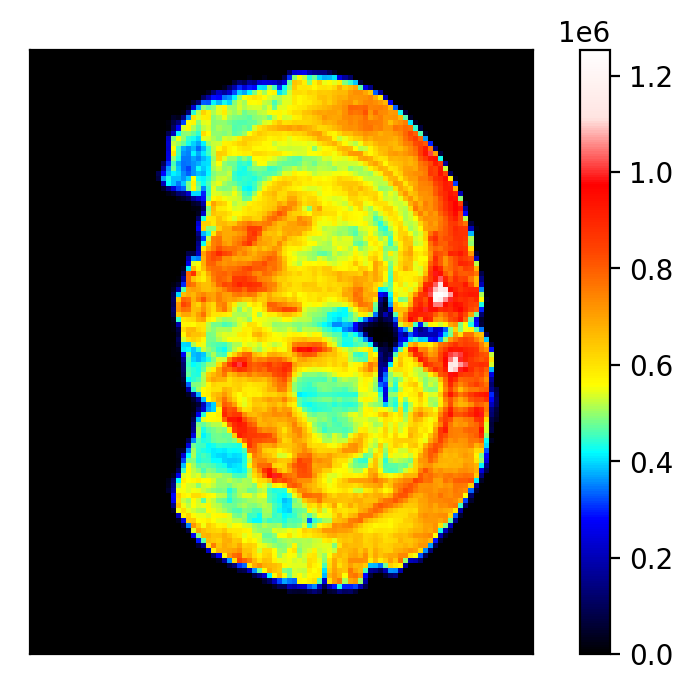

In [10]:
poolSize = np.sum(msi.data_tensor[goodInds],axis=0)
SIMSIToolBox.showImage(poolSize,cmap=colormap)

norm = plt.Normalize(vmin=poolSize.min(),vmax=poolSize.max())
norm = colormap(norm(poolSize))
for row in range(norm.shape[0]):
    for col in range(norm.shape[1]):
        if msi.imageBoundary[row,col] < .5:
            norm[row,col,3] = 0

plt.imsave(datadir + file.replace(".csv","") + "/poolsize.png",norm)
plt.savefig(datadir + file.replace(".csv","") + "/poolsize_with_colorbar.png")

(120, 100, 4)


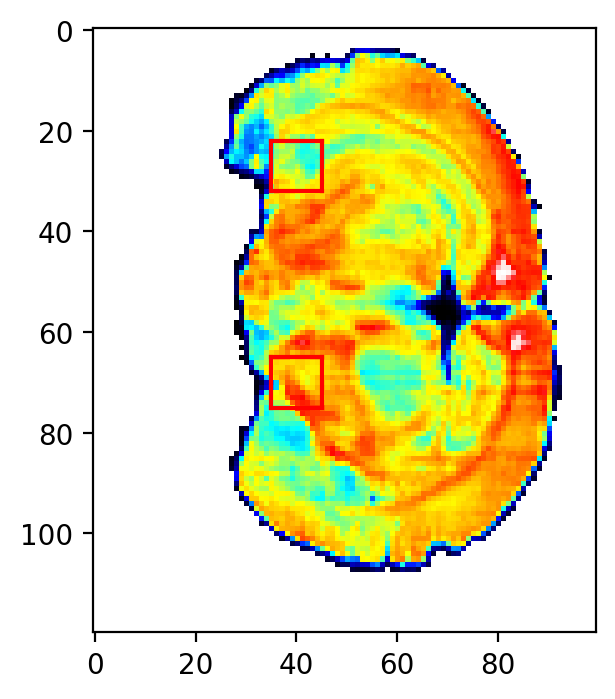

In [11]:
#add boxes
size = 10

box1x = 35
box1y = 22

box2x = 35
box2y = 65

def plotBox(xmin,ymin,color):
    xmax = xmin + size
    ymax = ymin + size
    plt.plot([xmin,xmax],[ymin,ymin],color)
    plt.plot([xmin,xmax],[ymax,ymax],color)
    plt.plot([xmin,xmin],[ymin,ymax],color)
    plt.plot([xmax,xmax],[ymin,ymax],color)
    
def addBox(xmin,ymin,color,image):
    image = deepcopy(image)
    xmax = xmin + size
    ymax = ymin + size
    image[xmin:xmax+1,ymin] = color
    image[xmin:xmax+1,ymax] = color
    image[xmin,ymin:ymax+1] = color
    image[xmax,ymin:ymax+1] = color
    return image
    

plt.imshow(norm)
    
plotBox(box1x,box1y,"red")
plotBox(box2x,box2y,"red")

print(norm.shape)

img = addBox(box1y,box1x,(1.0,0,0,1.0),norm)
img = addBox(box2y,box2x,(1.0,0,0,1.0),img)


plt.imsave(datadir + file.replace(".csv","") + "/poolsize.png",img)


In [12]:
# sb.set_theme(style="white",font_scale=.5)

# def extractLabelingPattern(data,xmin,ymin):
#     xmax = xmin + size
#     ymax = ymin + size
#     roi = []
#     for x in range(xmin,xmax+1):
#         for y in range(ymin,ymax+1):
#             roi.append(data[goodInds,x,y])
#     roi = np.array(roi)
    
#     df  = {}
#     for row in roi:
#         for x in range(len(goodInds)):
#            df[len(df)] = {"isotopologue":"M"+str(goodInds[x]),"Isotopologue Fraction":row[x]}

#     df = pd.DataFrame.from_dict(df,orient="index")

#     return df

# df = extractLabelingPattern(iso_tensor,box1y,box1x)

# fig,ax = plt.subplots(figsize=(5,4))

# ax.spines['right'].set_visible(False)
# ax.spines['top'].set_visible(False)


# sb.barplot(data=df,x="isotopologue",y="Isotopologue Fraction",capsize=.1,color="dimgrey",errwidth=1.5)
# plt.ylim((0,maxLabeling))
# plt.xlabel("")
# plt.tight_layout()
# plt.savefig(datadir + file.replace(".csv","") + "/box1.png")

# fig,ax = plt.subplots(figsize=(5,4))
# ax.spines['right'].set_visible(False)
# ax.spines['top'].set_visible(False)

# df = extractLabelingPattern(iso_tensor,box2y,box2x)

# sb.barplot(data=df,x="isotopologue",y="Isotopologue Fraction",capsize=.1,color="dimgrey",errwidth=1.5)
# plt.ylim((0,maxLabeling))
# plt.xlabel("")
# plt.tight_layout()
# plt.savefig(datadir + file.replace(".csv","") + "/box2.png")


In [13]:

# def extractLabelingPattern(data,xmin,ymin):
#     xmax = xmin + size
#     ymax = ymin + size
#     roi = []
#     for x in range(xmin,xmax+1):
#         for y in range(ymin,ymax+1):
#             roi.append(data[goodInds,x,y])
#     roi = np.array(roi)
    
#     df  = {}
#     for row in roi:
#         df[len(df)] = {"isotopologue":"unlabeled","Isotopologue Fraction":row[0]}
#         df[len(df)] = {"isotopologue":"labeled","Isotopologue Fraction":np.sum(row[1:])}

#     df = pd.DataFrame.from_dict(df,orient="index")

#     return df

# df = extractLabelingPattern(iso_tensor,box1y,box1x)

# fig,ax = plt.subplots(figsize=(5,4))

# ax.spines['right'].set_visible(False)
# ax.spines['top'].set_visible(False)


# sb.barplot(data=df,x="isotopologue",y="Isotopologue Fraction",capsize=.1,color="dimgrey",errwidth=1.5)
# plt.ylim((0,maxLabeling))
# plt.xlabel("")
# plt.tight_layout()
# plt.savefig(datadir + file.replace(".csv","") + "/box1.png")

# fig,ax = plt.subplots(figsize=(5,4))
# ax.spines['right'].set_visible(False)
# ax.spines['top'].set_visible(False)

# df = extractLabelingPattern(iso_tensor,box2y,box2x)

# sb.barplot(data=df,x="isotopologue",y="Isotopologue Fraction",capsize=.1,color="dimgrey",errwidth=1.5)
# plt.ylim((0,maxLabeling))
# plt.xlabel("")
# plt.tight_layout()
# plt.savefig(datadir + file.replace(".csv","") + "/box2.png")


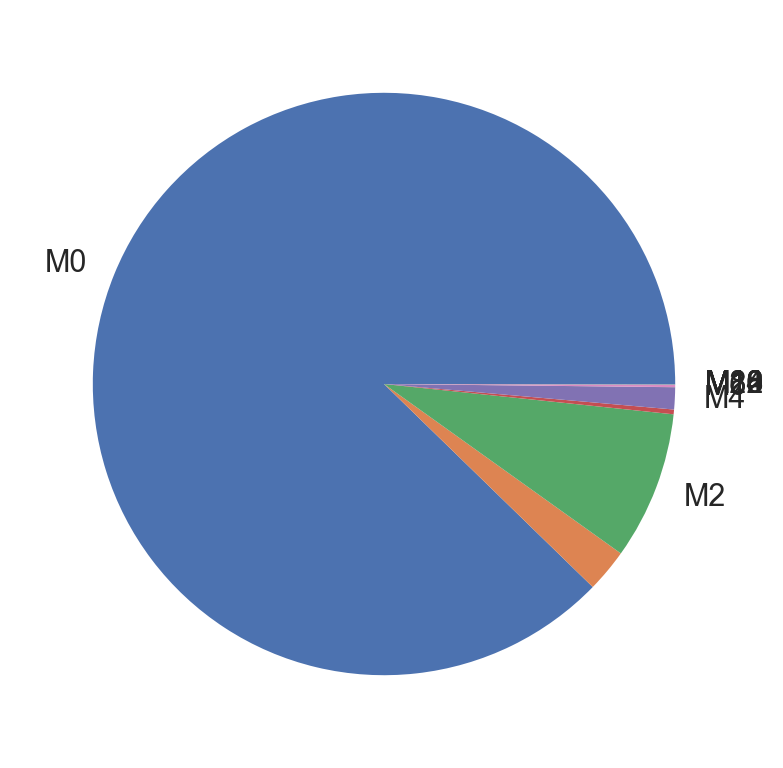

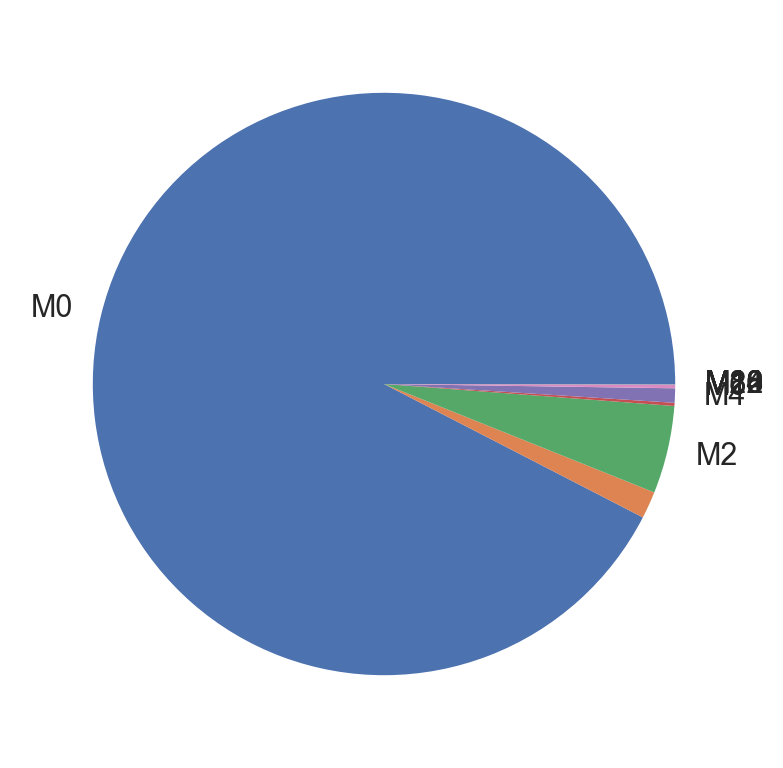

In [14]:
sb.set_theme(style="white",font_scale=1.0)

def extractLabelingPattern(data,xmin,ymin):
    xmax = xmin + size
    ymax = ymin + size
    roi = []
    for x in range(xmin,xmax+1):
        for y in range(ymin,ymax+1):
            roi.append(data[goodInds,x,y])
    roi = np.array(roi)
    
    roi = roi.mean(axis=0)
        
    return roi
    

roi = extractLabelingPattern(msi.data_tensor,box1y,box1x)

fig,ax = plt.subplots(figsize=(5,4))

labels = ["M"+str(x) for x in goodInds]

for x in range(1,len(goodInds),2):
    labels[x] = ""

plt.pie(x=roi,labels=labels,explode=[0] + [0 for x in range(len(goodInds)-1)],wedgeprops = {'linewidth': 0} )

plt.tight_layout()
plt.savefig(datadir + file.replace(".csv","") + "/box1.png")

fig,ax = plt.subplots(figsize=(5,4))

roi = extractLabelingPattern(msi.data_tensor,box2y,box2x)

plt.pie(x=roi,labels=labels,explode=[0] + [0 for x in range(len(goodInds)-1)],wedgeprops = {'linewidth': 0} )

plt.tight_layout()
plt.savefig(datadir + file.replace(".csv","") + "/box2.png")


In [16]:
file = files[0]
print(file)
formula = "C16H31O2"
m0Mz,mzsOI,numCarbons = SIMSIToolBox.getMzsOfIsotopologues(formula,elementOfInterest="C")
msi = SIMSIToolBox.MSIData(mzsOI,ppm=ppmThresh,numCores = num_cores,intensityCutoff=0)
df = pd.read_csv(datadir + file,index_col=0)
msi.from_pandas(df,polarity)

20210223_02_100w120h_13CtumorBrain2_009109H_01 009109H_1.csv


In [14]:
# if __name__ == "__main__":
#     filt = "GB"
#     convSquare = 3
#     msi.smoothData(filt,convSquare)

In [17]:
if __name__ == "__main__":
    fluxImageG,fluxImageD,fluxImageT0,fluxImageT1,fluxImageT2,T_founds,P_trues,P_preds,numFounds,errs,errors = msi.runISA()

Running ISA |██████████████████████████████████████████████████| 100.0% 


In [18]:
formula = "C20H31O2"
m0Mz,mzsOI,numCarbons = SIMSIToolBox.getMzsOfIsotopologues(formula,elementOfInterest="C")
msi = SIMSIToolBox.MSIData(mzsOI,ppm=ppmThresh,numCores = num_cores,intensityCutoff=0)
df = pd.read_csv(datadir + file,index_col=0)
msi.from_pandas(df,polarity)

In [19]:
if __name__ == "__main__":
    fluxImageE,fluxImageD,fluxImageT0,fluxImageT1,fluxImageT2,T_founds,P_trues,P_preds,numFounds,errs,errors = msi.runISA("dual",X_image=np.array([fluxImageT0,fluxImageT1,fluxImageT2]))

Running ISA |██------------------------------------------------| 4.2% 

Running ISA |████----------------------------------------------| 8.3% 

Running ISA |██████--------------------------------------------| 12.7% 

Running ISA |████████------------------------------------------| 16.6% 

Running ISA |██████████----------------------------------------| 20.7% 

Running ISA |████████████--------------------------------------| 24.5% 

Running ISA |██████████████------------------------------------| 28.7% 

Running ISA |███████████████-----------------------------------| 32.0% 

Running ISA |█████████████████---------------------------------| 35.2% 

Running ISA |███████████████████-------------------------------| 39.7% 

Running ISA |█████████████████████-----------------------------| 43.6% 

Running ISA |███████████████████████---------------------------| 47.8% 

Running ISA |██████████████████████████------------------------| 52.0% 

Running ISA |████████████████████████████----------------------| 56.1% 

Running ISA |██████████████████████████████--------------------| 60.5% 

Running ISA |████████████████████████████████------------------| 64.6% 

Running ISA |██████████████████████████████████----------------| 68.7% 

Running ISA |████████████████████████████████████--------------| 73.1% 

Running ISA |██████████████████████████████████████------------| 77.0% 

Running ISA |████████████████████████████████████████----------| 80.9% 

Running ISA |██████████████████████████████████████████--------| 84.6% 

Running ISA |████████████████████████████████████████████------| 88.2% 

Running ISA |██████████████████████████████████████████████----| 92.6% 

Running ISA |████████████████████████████████████████████████--| 96.6% 

Running ISA |██████████████████████████████████████████████████| 100.0% 


In [20]:
os.mkdir(datadir + file.replace(".csv","/"))

FileExistsError: [WinError 183] Cannot create a file when that file already exists: 'X:/MSI_Shared_Data/13CImagingManuscript/raw_data/imzmls/subset_data/NA_corrected_data/manuscript_figs/figure5/20210223_02_100w120h_13CtumorBrain2_009109H_01 009109H_1/'

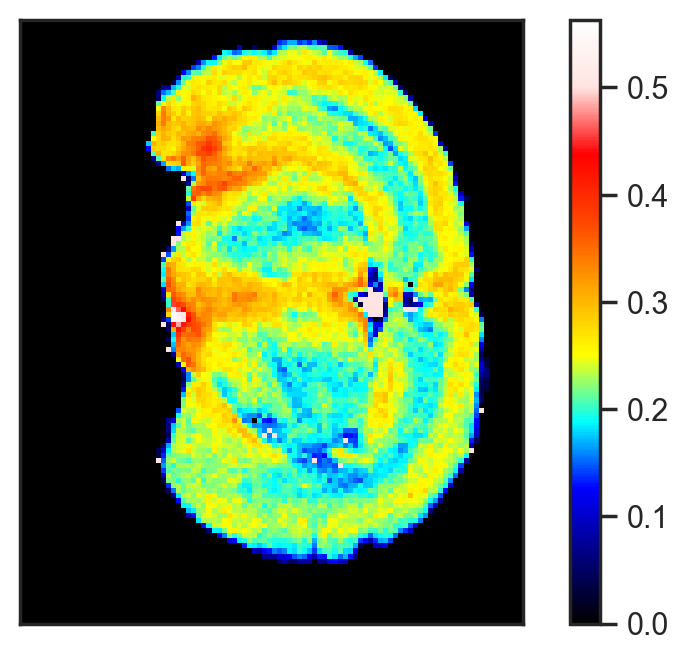

In [21]:
SIMSIToolBox.showImage(fluxImageG,cmap=colormap)

norm = plt.Normalize(vmin=fluxImageG.min(),vmax=fluxImageG.max())
norm = colormap(norm(fluxImageG))
for row in range(norm.shape[0]):
    for col in range(norm.shape[1]):
        if msi.imageBoundary[row,col] < .5:
            norm[row,col,3] = 0
plt.imsave(datadir + file.replace(".csv","") + "/gt.png",norm)


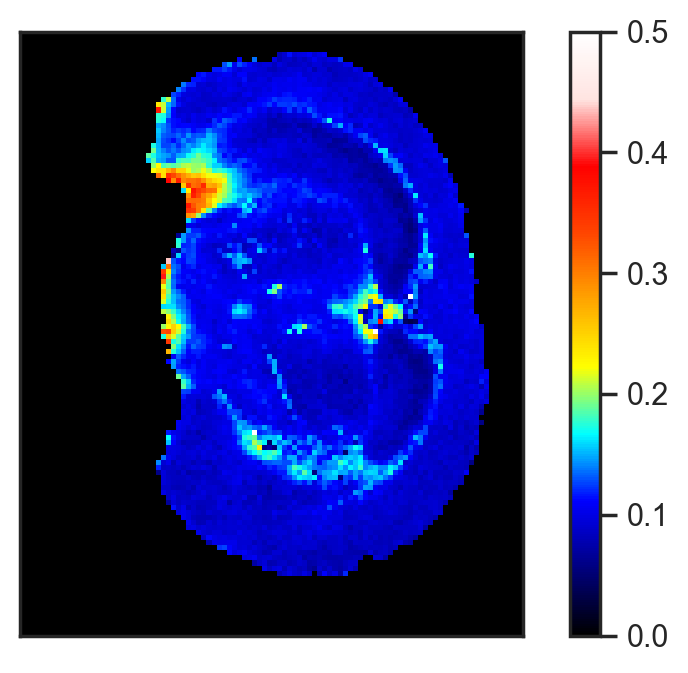

In [23]:
SIMSIToolBox.showImage(fluxImageE,cmap=colormap)

norm = plt.Normalize(vmin=fluxImageE.min(),vmax=fluxImageE.max())
norm = colormap(norm(fluxImageE))
for row in range(norm.shape[0]):
    for col in range(norm.shape[1]):
        if msi.imageBoundary[row,col] < .5:
            norm[row,col,3] = 0
plt.imsave(datadir + file.replace(".csv","") + "/et.png",norm)
